In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
from copy import deepcopy
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Input, Embedding, Concatenate

In [3]:
train_df = pd.read_csv('/content/drive/My Drive/DeepLearningColab/assignment2/StanceDataset/train.csv', sep=',', lineterminator='\r', encoding='latin-1')
test_df = pd.read_csv('/content/drive/My Drive/DeepLearningColab/assignment2/StanceDataset/test.csv', sep=',', lineterminator='\r', encoding='latin-1')
len(train_df), len(test_df)

(2914, 1956)

In [4]:
print(f"Train {train_df['Target'].value_counts()}\n")
print(f"Train {train_df['Stance'].value_counts()}\n")

print(f"Test {test_df['Target'].value_counts()}\n")
print(f"Test {test_df['Stance'].value_counts()}")

Train Target
Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: count, dtype: int64

Train Stance
AGAINST    1395
NONE        766
FAVOR       753
Name: count, dtype: int64

Test Target
Donald Trump                        707
Hillary Clinton                     295
Feminist Movement                   285
Legalization of Abortion            280
Atheism                             220
Climate Change is a Real Concern    169
Name: count, dtype: int64

Test Stance
AGAINST    1014
NONE        490
FAVOR       452
Name: count, dtype: int64


In [5]:
test_df = test_df[test_df['Target'] != 'Donald Trump']

# Data Processing

## Word embedding with GLOVE

In [6]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

--2025-01-11 08:05:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-11 08:05:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-11 08:05:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [7]:
# Create a dictionary of words and their corresponding vectors
words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')
      try:
        d[line[0]] = np.array(line[1:], dtype=float) # Grab first word as key then values as numpy array
      except:
        continue

add_to_dict(words, 'glove.6B.50d.txt')
len(words)

400000

## Tokenizer and Lemmatization

In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Tokenize and lemmatize the words
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
lemmatizer = nltk.stem.WordNetLemmatizer()

# Convert a message to a list of tokens
def message_to_token(s):
  tokens = tokenizer.tokenize(s)
  lowercase_tokens = [t.lower() for t in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercase_tokens]
  useful_tokens = [t for t in lemmatized_tokens if t in words]
  return useful_tokens

In [10]:
message_to_token(train_df['Tweet'][0])

['and',
 'she',
 'wiped',
 'clean',
 '30k',
 'deleted',
 'email',
 'explains',
 'dereliction',
 'of',
 'duty',
 'lie',
 're',
 'benghazi',
 'etc']

In [11]:
# Convert a message to a list of word vectors
def message_to_word_vectors(message, word_dict=words):
  list_of_tokens = message_to_token(message)

  vectors = []

  for token in list_of_tokens:
    if token not in word_dict:
      continue # leave token not in word_dict for now
    token_vector = word_dict[token]
    vectors.append(word_dict[token])

  return np.array(vectors, dtype=float)

In [12]:
message_to_word_vectors(train_df['Tweet'][0]).shape

(15, 50)

## Prepare data for DL model

In [13]:
# Randomly shuffles all rows in the dataframe, reset the index to be sequential. This is a part of pipeline.
train_df = train_df.sample(frac=1, random_state=42)
train_df.reset_index(drop=True, inplace=True)
train_df

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,Beauty is in the eye of the goat. #AddGoatRuin...,Feminist Movement,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
1,As late as 2013 #HillaryClinton opposed marria...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
2,Tip for protesters everywhere: your goal is to...,Legalization of Abortion,NONE,2. The tweet does NOT expresses opinion about ...,neg
3,@ClimateCentral @ChristineMilne Some people r ...,Climate Change is a Real Concern,NONE,2. The tweet does NOT expresses opinion about ...,neg
4,#LikeAFeminist if you don't identify as a femi...,Feminist Movement,FAVOR,1. The tweet explicitly expresses opinion abo...,neg
...,...,...,...,...,...
2909,@chelss_21x love how it doesn't distract femal...,Feminist Movement,NONE,3. The tweet is not explicitly expressing opi...,neg
2910,@dancerlwt Have you considered changing your T...,Feminist Movement,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
2911,RT @WeNeedFeminism: I don't want to choose bet...,Feminist Movement,FAVOR,1. The tweet explicitly expresses opinion abo...,neg
2912,were even is the clifford on a Virginia? #stop...,Feminist Movement,NONE,2. The tweet does NOT expresses opinion about ...,neg


In [14]:
# Create the encoder
encode_target = {
  'Hillary Clinton' : 0,
  'Legalization of Abortion'  : 1,
  'Atheism' : 2,
  'Climate Change is a Real Concern' : 3,
  'Feminist Movement'  : 4
}

encode_stance = {
  'AGAINST' : 0,
  'NONE' : 1,
  'FAVOR'  : 2
}

In [15]:
# Apply encoding for Stance feature
train_df['Stance'] = train_df['Stance'].apply(lambda x: encode_stance[x])
test_df['Stance'] = test_df['Stance'].apply(lambda x: encode_stance[x])

# Apply encoding for Target feature
train_df['Target'] = train_df['Target'].apply(lambda x: encode_target[x])
test_df['Target'] = test_df['Target'].apply(lambda x: encode_target[x])

In [16]:
def df_to_X_y(df):
  y_target = df['Target'].to_numpy().astype(int)
  y_stance = df['Stance'].to_numpy().astype(int)

  all_words_vector = []

  for message in df['Tweet']:
    message_as_vector = message_to_word_vectors(message)

    if message_as_vector.shape[0] == 0:
      message_as_vector = np.zeroes(shape=(1, 50))

    all_words_vector.append(message_as_vector)

  return all_words_vector, y_target, y_stance

In [17]:
X_train, y_train_target, y_train_stance = df_to_X_y(train_df)
X_test, y_test_target, y_test_stance = df_to_X_y(test_df)

# Expecting messages to vector different for each tweet
print(len(X_train), len(X_train[0]))
print(len(X_train), len(X_train[2]))

2914 9
2914 23


<ipython-input-18-cc59c8b4b45c>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sequence_length, hist=True)


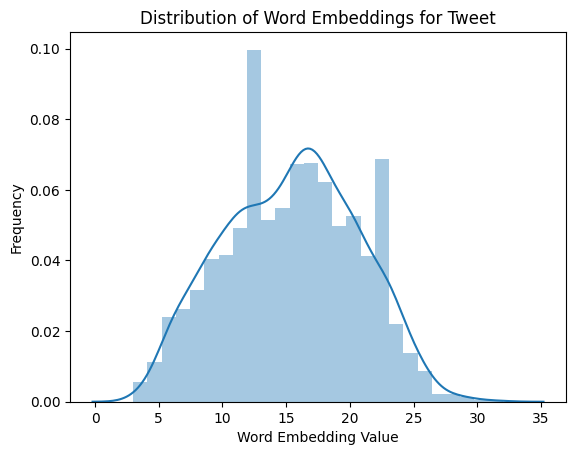

In [18]:
sequence_length = []

for i in range(len(X_train)):
  sequence_length.append(len(X_train[i]))

sns.distplot(sequence_length, hist=True)
plt.title(f'Distribution of Word Embeddings for Tweet')
plt.xlabel('Word Embedding Value')
plt.ylabel('Frequency')
plt.show()

In [19]:
pd.Series(sequence_length).describe()

,0
count,2914.000000
mean,15.407344
std,5.245942
min,3.000000
25%,11.000000
50%,16.000000
75%,19.000000
max,32.000000


## Padding

In [20]:
# Pad the sequences to be the same length
def pad_X(X, desrired_length=35):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_different = desrired_length - x_seq_len

    pad = np.zeros(shape=(sequence_length_different, 50))
    X_copy[i] = np.concatenate([x, pad])

  return np.array(X_copy).astype(float)

In [21]:
X_train_pad = pad_X(X_train)
X_test_pad = pad_X(X_test)

# Print shape of train test split for both target and stance
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train_target:', y_train_target.shape)
print('Shape of y_train_stance:', y_train_stance.shape)

print('Shape of X_test:', X_test_pad.shape)
print('Shape of y_test_target:', y_test_target.shape)
print('Shape of y_test_stance:', y_test_stance.shape)

Shape of X_train_pad: (2914, 35, 50)
Shape of y_train_target: (2914,)
Shape of y_train_stance: (2914,)
Shape of X_test: (1249, 35, 50)
Shape of y_test_target: (1249,)
Shape of y_test_stance: (1249,)


# Model

In [25]:
def create_bilstm_model(text_shape=(35, 50), num_classes=None):
    # Get number of unique classes if not provided
    if num_classes is None:
        num_classes = len(np.unique(y_train_stance))

    # Text input branch
    text_input = Input(shape=text_shape, name='text_input')
    x1 = Bidirectional(LSTM(128, return_sequences=True))(text_input)
    x1 = Dropout(0.3)(x1)
    x1 = Bidirectional(LSTM(64))(x1)
    x1 = Dropout(0.3)(x1)

    # Target input branch
    target_input = Input(shape=(1,), name='target_input')
    x2 = Dense(32, activation='relu')(target_input)

    # Combine both branches
    combined = Concatenate()([x1, x2])

    # Dense layers for final prediction
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create model with multiple inputs
    model = Model(inputs=[text_input, target_input], outputs=output)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and summarize the model
model = create_bilstm_model()
model.summary()

# Reshape target input to have shape (samples, 1)
y_train_target_reshaped = y_train_target.reshape(-1, 1)
y_test_target_reshaped = y_test_target.reshape(-1, 1)

# Train the model
history = model.fit(
    [X_train_pad, y_train_target_reshaped],  # Two inputs
    y_train_stance,  # Stance prediction output
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(
    [X_test_pad, y_test_target_reshaped],
    y_test_stance
)
print(f"\nTest accuracy: {test_accuracy:.4f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 35, 50)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 35, 256)        │        183,296 │ text_input[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 35, 256)        │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 128)            │        164,352 │ dropout_3[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_input (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │             64 │ target_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 160)            │              0 │ dropout_4[0][0],       │
│ (Concatenate)             │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │         10,304 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 3)              │            195 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 358,211 (1.37 MB)

 Trainable params: 358,211 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.4618 - loss: 1.0695 - val_accuracy: 0.5146 - val_loss: 0.9949
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5311 - loss: 0.9926 - val_accuracy: 0.5403 - val_loss: 0.9492
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5413 - loss: 0.9641 - val_accuracy: 0.5712 - val_loss: 0.9295
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5676 - loss: 0.9121 - val_accuracy: 0.5712 - val_loss: 0.9317
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6040 - loss: 0.8769 - val_accuracy: 0.5557 - val_loss: 0.9279
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6343 - loss: 0.8419 - val_accuracy: 0.5746 - val_loss: 0.9031
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6585 - loss: 0.8020 - val_accuracy: 0.5763 - val_loss: 0.9118
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6721 - loss: 0.7677 - val_accuracy: 0.5883 - 

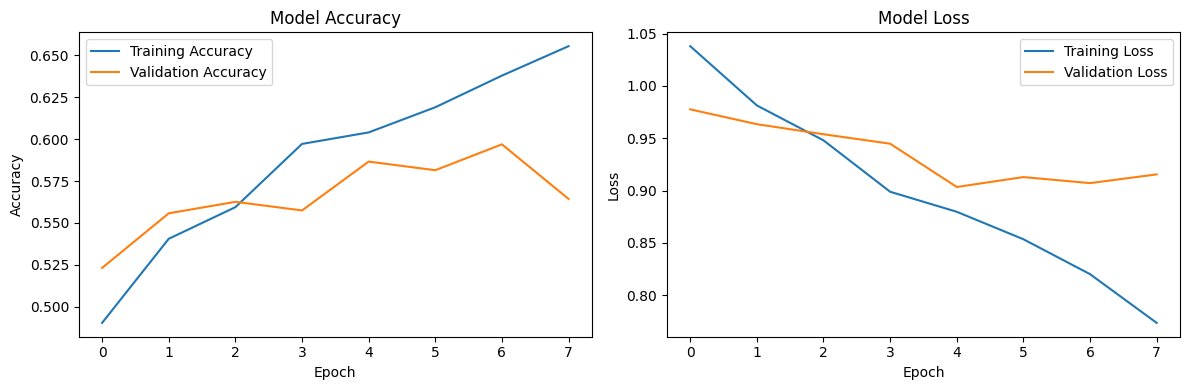

In [23]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Save the model
model.save('bilstm_stance_model.keras')

# Generate predictions
y_pred = model.predict([X_test_pad, y_test_target_reshaped])
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_stance, y_pred_classes))

# Save classification report to a file (optional)
with open('classification_report.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(classification_report(y_test_stance, y_pred_classes))

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       715
           1       0.36      0.49      0.42       230
           2       0.53      0.39      0.45       304

    accuracy                           0.59      1249
   macro avg       0.53      0.53      0.52      1249
weighted avg       0.60      0.59      0.59      1249

